In [6]:
import Scribe as sc
from Scribe.Scribe import causal_net_dynamics_coupling as Scribe

import scanpy as sp
from anndata import AnnData

import pandas as pd
import numpy as np 

import networkx as nx 
nx.__version__

import matplotlib.pyplot as plt


In [18]:
def read_data(filename, fillna=False):
    X = pd.read_csv(filename, index_col=0, delimiter=',')
    if fillna: X.fillna(0, inplace=True)
    split_array = [X.columns.str.split('_', n=5)[i] for i in range(len(X.columns))]
    obs = pd.DataFrame(split_array, columns=['Plate', 'Well', 'Exp', 'CellType', 'Time', 'Treatment'])
    obs['cell_id'] = X.columns
    obs = obs.set_index('cell_id')
#     print(X.index[:10])
    
    var = pd.DataFrame(X.index, columns=['Ensemble_id'])
    return X.values.T, obs, var

In [76]:
directory = '/home/xqiu/proj/Aristotle/scSLAM_seq_data/NASC_seq'
adata = []
for i in [2, 3, 4]:
    N, obs, var = read_data("%s/GSE128273_exp%d_newcounts.csv"%(directory, i))
    O, _, _ = read_data("%s/GSE128273_exp%d_oldcounts.csv"%(directory, i))
    R, _, _ = read_data("%s/GSE128273_exp%d_readcounts.csv"%(directory, i))
    adata.append(AnnData(R, obs=obs, var=var, layers={'unspliced': N, 'spliced': O}))
adata = AnnData.concatenate(*adata)
print(adata)

Index(['ENSG00000223972', 'ENSG00000227232', 'ENSG00000278267',
       'ENSG00000243485', 'ENSG00000284332', 'ENSG00000237613',
       'ENSG00000268020', 'ENSG00000240361', 'ENSG00000186092',
       'ENSG00000238009'],
      dtype='object')
Index(['ENSG00000223972', 'ENSG00000227232', 'ENSG00000278267',
       'ENSG00000243485', 'ENSG00000284332', 'ENSG00000237613',
       'ENSG00000268020', 'ENSG00000240361', 'ENSG00000186092',
       'ENSG00000238009'],
      dtype='object')


Transforming to str index.


Index(['ENSG00000223972', 'ENSG00000227232', 'ENSG00000278267',
       'ENSG00000243485', 'ENSG00000284332', 'ENSG00000237613',
       'ENSG00000268020', 'ENSG00000240361', 'ENSG00000186092',
       'ENSG00000238009'],
      dtype='object')
Index(['ENSG00000223972', 'ENSG00000227232', 'ENSG00000278267',
       'ENSG00000243485', 'ENSG00000284332', 'ENSG00000237613',
       'ENSG00000268020', 'ENSG00000240361', 'ENSG00000186092',
       'ENSG00000238009'],
      dtype='object')
Index(['ENSG00000223972', 'ENSG00000227232', 'ENSG00000278267',
       'ENSG00000243485', 'ENSG00000284332', 'ENSG00000237613',
       'ENSG00000268020', 'ENSG00000240361', 'ENSG00000186092',
       'ENSG00000238009'],
      dtype='object')


Transforming to str index.


Index(['ENSG00000223972', 'ENSG00000227232', 'ENSG00000278267',
       'ENSG00000243485', 'ENSG00000284332', 'ENSG00000237613',
       'ENSG00000268020', 'ENSG00000240361', 'ENSG00000186092',
       'ENSG00000238009'],
      dtype='object')
Index(['ENSG00000223972', 'ENSG00000227232', 'ENSG00000278267',
       'ENSG00000243485', 'ENSG00000284332', 'ENSG00000237613',
       'ENSG00000268020', 'ENSG00000240361', 'ENSG00000186092',
       'ENSG00000238009'],
      dtype='object')
Index(['ENSG00000223972', 'ENSG00000227232', 'ENSG00000278267',
       'ENSG00000243485', 'ENSG00000284332', 'ENSG00000237613',
       'ENSG00000268020', 'ENSG00000240361', 'ENSG00000186092',
       'ENSG00000238009'],
      dtype='object')


Transforming to str index.


Index(['ENSG00000223972', 'ENSG00000227232', 'ENSG00000278267',
       'ENSG00000243485', 'ENSG00000284332', 'ENSG00000237613',
       'ENSG00000268020', 'ENSG00000240361', 'ENSG00000186092',
       'ENSG00000238009'],
      dtype='object')
AnnData object with n_obs × n_vars = 576 × 58428 
    obs: 'CellType', 'Exp', 'Plate', 'Time', 'Treatment', 'Well', 'batch'
    var: 'Ensemble_id'
    layers: 'unspliced', 'spliced'


In [21]:
import mygene
mg = mygene.MyGeneInfo()
geneList = adata.var.Ensemble_id
geneSyms = mg.querymany(geneList , scopes='ensembl.gene', fields='symbol', species='human')


In [77]:
Ensemble_id = [cur_dict['query'] for cur_dict in geneSyms]
gene = [cur_dict['symbol'] if 'notfound' not in cur_dict.keys() else 'NA' for cur_dict in geneSyms]
FD = pd.DataFrame({'Ensemble_id': Ensemble_id, "gene_short_name": gene}, columns=['Ensemble_id', 'gene_short_name'])
FD = FD.set_index('Ensemble_id')

tmp = FD.loc[adata.var.Ensemble_id, :]
tmp = tmp.iloc[np.where(~ FD.index.duplicated())[0], :]
adata.var = tmp



In [78]:
adata.var[adata.var.gene_short_name.isin(['EGR1','FOS'])]


,gene_short_name
Ensemble_id,
ENSG00000120738,EGR1
ENSG00000170345,FOS


/home/xqiu/.local/lib/python3.6/site-packages/Scribe/causal_network.py:18: UserWarning:  WARNING: No expression data argument given. if you intend to load the data from a file, call the method 'read_expression_file'.
  if expression==None: warnings.warn(" WARNING: No expression data argument given. if you intend to load the data from a file, call the method 'read_expression_file'.")


Create causal_model successfully


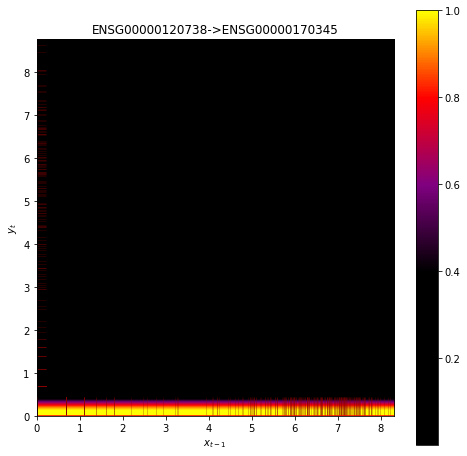

In [79]:
sc.pl.viz_response(adata, np.array([['ENSG00000120738','ENSG00000170345']]),grid_num=25, log=True) # 


Create causal_model successfully


/home/xqiu/.local/lib/python3.6/site-packages/Scribe/plot/heatmaps.py:394: RuntimeWarning: invalid value encountered in true_divide
  u = np.exp(-dist_mat[i, 1:] / np.min(dist_mat[i, 1:]))


f_ini_ind is  0   25


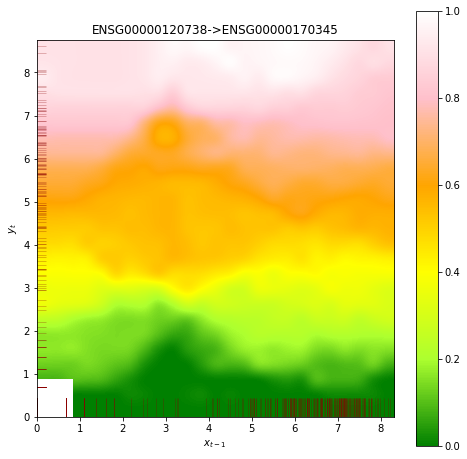

In [80]:
sc.pl.viz_causality(adata,np.array([['ENSG00000120738','ENSG00000170345']]),grid_num=25, log=True)


In [81]:
adata.var[adata.var.gene_short_name.isin(['EGR1','FOS', 'DUSP2'])]


,gene_short_name
Ensemble_id,
ENSG00000158050,DUSP2
ENSG00000120738,EGR1
ENSG00000170345,FOS


Create causal_model successfully


/home/xqiu/.local/lib/python3.6/site-packages/Scribe/plot/heatmaps.py:551: RuntimeWarning: invalid value encountered in true_divide
  u = np.exp(-dist_mat[i, 1:] / np.min(dist_mat[i, 1:]))


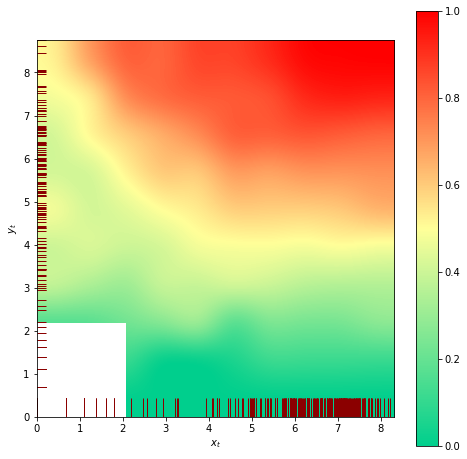

In [82]:
sc.pl.viz_comb_logic(adata,np.array([['ENSG00000120738','ENSG00000170345', 'ENSG00000158050']]),grid_num=10, log=True)


In [83]:
sp.pp.recipe_zheng17(adata, n_top_genes=25) #, min_counts=15, min_counts_u=10, n_top_genes=2500 n_top_genes can be tuned 
Scribe(adata, t0_key='spliced', t1_key='unspliced')


/home/xqiu/.local/lib/python3.6/site-packages/Scribe/information_estimators.py:171: RuntimeWarning: invalid value encountered in double_scalars
  information_samples[i] += -digamma(len(tree_yz.query_ball_point(data_yz[i], knn_dis[i], p=np.inf)) - 1)
/home/xqiu/.local/lib/python3.6/site-packages/Scribe/information_estimators.py:170: RuntimeWarning: invalid value encountered in double_scalars
  information_samples[i] += -digamma(len(tree_xz.query_ball_point(data_xz[i], knn_dis[i], p=np.inf)) - 1)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:75: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


In [108]:
adata.uns['causal_net']

,ENSG00000198691,ENSG00000115919,ENSG00000154743,ENSG00000053108,ENSG00000101812,ENSG00000261026,ENSG00000236521,ENSG00000230417,ENSG00000255920,ENSG00000214851,...,ENSG00000231870,ENSG00000275302,ENSG00000266928,ENSG00000210082,gERCC.00002,gERCC.00043,gERCC.00092,gERCC.00136,gERCC.00145,gERCC.00170
ENSG00000198691,NaN,0.020791,NaN,NaN,0.000715,NaN,inf,NaN,NaN,inf,...,NaN,1.548182e-04,NaN,0.004311,0.052951,inf,NaN,NaN,0.302689,0.064591
ENSG00000115919,NaN,NaN,0.000709,NaN,NaN,NaN,0.022573,NaN,NaN,2.257204e-02,...,-6.180066e-04,NaN,NaN,0.036033,0.067136,-0.027034,NaN,NaN,0.300790,0.018590
ENSG00000154743,0.019651,NaN,NaN,0.012259,0.002554,NaN,inf,0.000891,NaN,inf,...,9.794088e-04,NaN,0.0,NaN,0.132055,-0.083623,NaN,NaN,0.153946,0.123731
ENSG00000053108,0.014821,0.032511,NaN,NaN,0.000966,NaN,NaN,NaN,-1.270485e-03,NaN,...,-6.111247e-04,2.586374e-04,NaN,NaN,0.021976,NaN,NaN,NaN,0.305708,0.030424
ENSG00000101812,NaN,0.019407,NaN,NaN,NaN,NaN,inf,NaN,NaN,inf,...,NaN,-8.183052e-06,NaN,0.012068,0.149963,inf,NaN,NaN,0.297953,NaN
ENSG00000261026,NaN,NaN,0.072120,NaN,NaN,NaN,inf,NaN,NaN,NaN,...,NaN,NaN,NaN,0.362022,0.620648,inf,NaN,NaN,0.566561,0.619008
ENSG00000236521,NaN,NaN,NaN,0.000006,NaN,NaN,NaN,0.000011,-4.512816e-05,-1.805193e-05,...,-inf,1.723874e-07,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000230417,-0.002121,0.001936,NaN,0.000378,0.000099,NaN,NaN,NaN,NaN,NaN,...,6.285138e-05,NaN,NaN,0.012068,0.015635,inf,NaN,NaN,0.301979,0.015827
ENSG00000255920,-0.001682,0.019178,0.071992,NaN,0.001162,NaN,-0.000045,0.001699,NaN,-2.997941e-05,...,5.321209e-07,8.806282e-04,NaN,NaN,0.617652,0.001689,NaN,NaN,0.299555,0.619795
ENSG00000214851,NaN,NaN,NaN,0.030864,NaN,NaN,-0.000018,-0.001153,-2.997941e-05,NaN,...,1.800790e-07,8.681794e-04,NaN,0.003279,NaN,NaN,NaN,inf,NaN,NaN


In [116]:
df_mat = adata.uns['causal_net']
ind_mat = np.where(df_mat.values - df_mat.T.values < 0)

tmp = np.where(df_mat.values - df_mat.T.values < 0)

for i in range(len(tmp[0])): 
    df_mat.iloc[tmp[0][i], tmp[1][i]] = np.nan

df_mat = df_mat.stack().reset_index()
df_mat.columns = ['source', 'target', 'weight']
# df_mat = df_mat.iloc[df_mat['weight'] is not np.nan, :]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in subtract
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


In [117]:
df_mat.head()

,source,target,weight
0,ENSG00000198691,ENSG00000115919,0.020791
1,ENSG00000198691,ENSG00000101812,0.000715
2,ENSG00000198691,ENSG00000236521,inf
3,ENSG00000198691,ENSG00000214851,inf
4,ENSG00000198691,ENSG00000274012,0.254174


In [122]:
df_mat.source = FD.loc[df_mat.source, 'gene_short_name'].tolist()
df_mat.target = FD.loc[df_mat.target, 'gene_short_name'].tolist()

df_mat = df_mat.iloc[~np.isinf(df_mat.weight.tolist()), :]

G = nx.from_pandas_edgelist(df_mat, source='source', target='target', edge_attr='weight', create_using=nx.DiGraph())
G.nodes()
W = []
for n, nbrs in G.adj.items():
    for nbr, eattr in nbrs.items():
        W.append(eattr['weight'])
        
W[:10]


[0.020791127060745845,
 0.0007151298207218018,
 0.2541740435463706,
 0.0001548182254552126,
 0.004311273985621211,
 0.06459131122399316,
 0.0007092011558891739,
 0.02257303111067522,
 0.022572042173564153,
 0.2466700259544954]

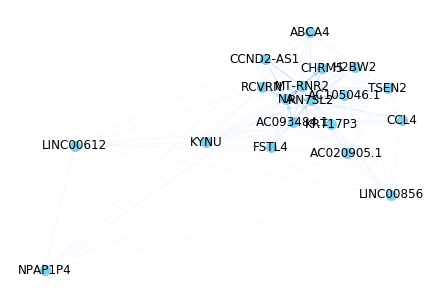

In [123]:
 
# Build a dataframe with your connections
 
# The order of the node for networkX is the following order:
G.nodes()
# Thus, we cannot give directly the 'myvalue' column to netowrkX, we need to arrange the order!
 
# Here is the tricky part: I need to reorder carac, to assign the good color to each node
# df=df.reindex(G.nodes())
 
# Plot it, providing a continuous color scale with cmap:
# df_mat['weight'].tolist()
nx.draw(G, with_labels=True, node_color='skyblue', node_size=100, edge_color=W, width=1.0, edge_cmap=plt.cm.Blues)